In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import json
import itertools
from pandas.io.json import json_normalize
import community

## INICIO DA COLETA DE DADOS

In [2]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    return categories_list[0]['name']

In [3]:
CLIENT_ID = '55LWIFZLZNZPSTAZZQKJXBD11BSBCUZTZPIXWVV4RFZJP1HS' # your Foursquare ID
CLIENT_SECRET = 'RPCOWGHQY5YNQUCHQUTC5VLKEYFGZN15FSIYTK5GNXNZ301E' # your Foursquare Secret
VERSION = '20180604'

In [4]:
latitude_nyork = 40.785091
longitude_nyork = -73.968285
radius = 10000
LIMIT = 100

In [5]:
QUERY = ''
url = 'https://api.foursquare.com/v2/venues/explore?time=any&query={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    QUERY, CLIENT_ID, CLIENT_SECRET, latitude_nyork, longitude_nyork, VERSION, radius, LIMIT)
results = requests.get(url).json()
locais = results['response']['groups'][0]['items']
locais_proximos = json_normalize(locais)
filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
locais_proximos = locais_proximos.loc[:, filtered_columns]
locais_proximos.columns = [col.split(".")[-1] for col in locais_proximos.columns]
locais_proximos['categories'] = locais_proximos.apply(get_category_type, axis=1)
locais_proximos.tail(10)

,id,name,categories,lat,lng
90,51c080d9abd88bfe62869a59,sweetgreen,Salad Place,40.744802,-73.988644
91,45940e37f964a52055401fe3,Kalustyan's,Gourmet Shop,40.742832,-73.982267
92,56e202d1498eb4f0d9ffcd68,Covina,Mediterranean Restaurant,40.742641,-73.983214
93,424de080f964a520aa201fe3,Museum of the Moving Image,Museum,40.756097,-73.924010
94,4a7b7f02f964a52037eb1fe3,Canoe Studios,Event Space,40.751750,-74.006765
95,4aeddba9f964a52096cf21e3,"Sal, Kris & Charlie's Deli",Sandwich Place,40.773304,-73.911434
96,40b68100f964a5207d001fe3,Madison Square Park,Park,40.742262,-73.988006
97,442e41b2f964a520da311fe3,Gagosian Gallery,Art Gallery,40.749493,-74.006050
98,4c5ef77bfff99c74eda954d3,Eataly,Gourmet Shop,40.741997,-73.989623
99,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205


In [6]:
checkins_locais = pd.DataFrame()
for i,local in locais_proximos.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}&limit={}'.format(
    local['id'], CLIENT_ID, CLIENT_SECRET, VERSION, 10000)
    results = requests.get(url).json()
    if (results['response']['likes']['count'] > 0) & ('items' in results['response']['likes']):
        results_2 = results['response']['likes']['items']
        checkins = json_normalize(results_2)[['id', 'firstName', 'gender']]
        checkins['avenue_id'] = local['id']
        checkins['avenue_name'] = local['name']
        checkins['avenue_categories'] = local['categories']
        checkins['avenue_lat'] = local['lat']
        checkins['avenue_lng'] = local['lng']
        if checkins_locais.empty:
            checkins_locais = checkins
        else:
            checkins_locais = pd.concat([checkins_locais, checkins], ignore_index=True)

In [7]:
#checkins_locais.to_csv('victor_likes_NY_geral.csv', index=False)

In [2]:
checkins_locais = pd.read_csv('victor_likes_NY_geral.csv')

In [3]:
checkins_locais.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
120873,155281,Eric,male,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120874,75374383,Corinne,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120875,23147845,Lindsey,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120876,15370863,Julie,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120877,76392,Sara,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205


In [6]:
locais_vc = checkins_locais['avenue_id'].value_counts()
locais_filter = locais_vc[locais_vc <= 650].index.tolist()

In [7]:
len(locais_filter)

62

In [8]:
likes_completo = checkins_locais[checkins_locais['avenue_id'].isin(locais_filter)]

In [9]:
likes_completo.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
120873,155281,Eric,male,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120874,75374383,Corinne,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120875,23147845,Lindsey,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120876,15370863,Julie,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205
120877,76392,Sara,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205


In [10]:
len(likes_completo)

16465

In [11]:
vc = likes_completo['id'].value_counts()

In [24]:
filter = vc[vc >= 2].index.tolist()

In [25]:
usuarios_unicos = likes_completo[likes_completo['id'].isin(filter)]['id'].drop_duplicates()

In [26]:
usuarios_unicos = usuarios_unicos.tolist()

In [27]:
len(usuarios_unicos)

2429

In [28]:
locais_unicos = likes_completo[likes_completo['id'].isin(filter)]['avenue_id'].drop_duplicates()

In [29]:
locais_unicos = locais_unicos.tolist()

In [30]:
len(locais_unicos)

62

In [31]:
len(likes_completo[likes_completo['id'].isin(filter)])

6670

In [32]:
grafo = nx.Graph()
for usuarios in usuarios_unicos:
    grafo.add_node(str(usuarios), 
           nome=likes_completo[likes_completo['id']==usuarios]['firstName'].values[0],
           genero=likes_completo[likes_completo['id']==usuarios]['gender'].values[0])
print(nx.number_of_nodes(grafo))
for local in locais_unicos:
    # pessoas que deram like...
    pessoas = list(likes_completo[
        (likes_completo['avenue_id'] == local) & (likes_completo['id'].isin(filter))
    ]['id'].drop_duplicates().values)
    combinacoes = itertools.combinations(pessoas, 2)
    for comb in combinacoes:
        u = comb[0]
        outro = comb[1]
        if grafo.has_edge(str(u), str(outro)):
            grafo[str(u)][str(outro)]['weight'] = grafo[str(u)][str(outro)]['weight'] + 1
        else:
            grafo.add_edge(str(u), str(outro), weight=1)

2429


In [33]:
nx.write_gml(grafo, 'grafo_geral_NY_reduzido_2.gml')

In [3]:
grafo = nx.read_gml('grafo_geral_NY_reduzido_2.gml')

In [34]:
nx.number_of_nodes(grafo)

2429

In [35]:
nx.number_of_edges(grafo)

455374

In [36]:
np.mean([grau[1] for grau in list(nx.degree(grafo, weight='weight'))])

419.3017702758337

In [37]:
np.mean(list(nx.degree_centrality(grafo).values()))

0.15442657129699272

In [38]:
np.mean(list(nx.eigenvector_centrality(grafo, weight='weight').values()))

0.016740407531903336

In [53]:
np.mean(list(nx.betweenness_centrality(grafo, weight='weight').values()))

0.0003556057537329592

In [54]:
nx.average_clustering(grafo, weight='weight')

0.06692713689234844

In [55]:
eccent = nx.eccentricity(grafo)

In [58]:
np.mean(list(eccent.values()))

2.45944833264718

In [39]:
pos = nx.spring_layout(grafo)

d:\git\analysis-geospatial-data\venv\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


(-1.0811513469369602,
 0.6989887277895234,
 -0.6997547196263323,
 0.607774211312192)

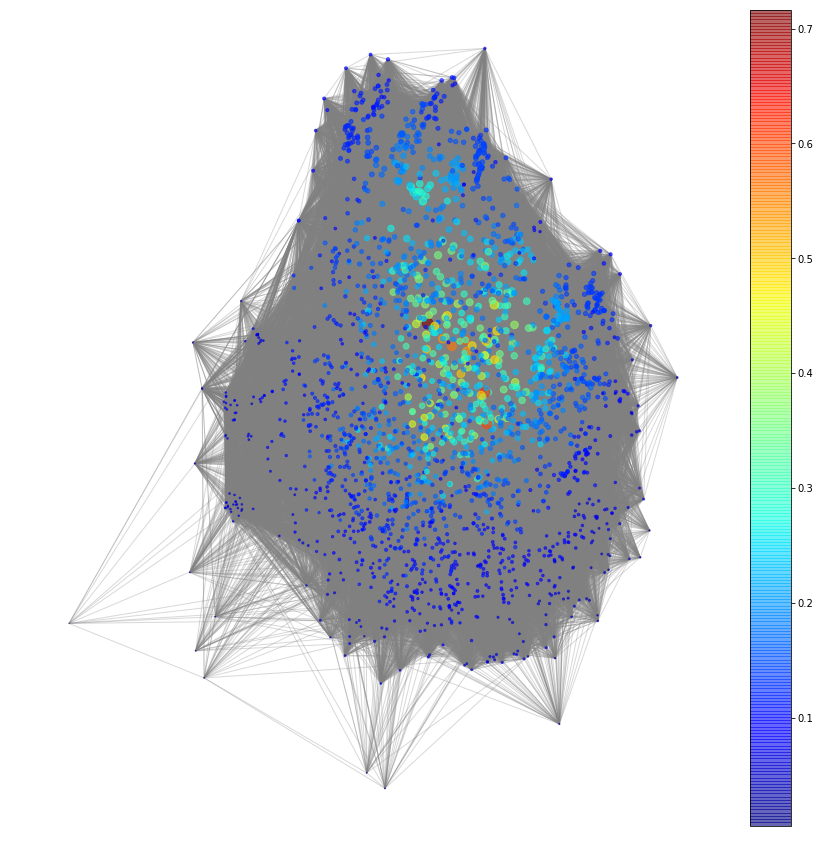

In [40]:

node_color = [cent for cent in nx.degree_centrality(grafo).values()]
node_size = [eigen * 1000 for eigen in list(nx.eigenvector_centrality(grafo, weight='weight').values())]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo, pos=pos, alpha=0.3, edge_color='gray')
no = nx.draw_networkx_nodes(grafo, pos=pos, alpha=0.6, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=min(list(nx.degree_centrality(grafo).values())), 
                            vmax=max(list(nx.degree_centrality(grafo).values())),
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')

(-1.0811513469369602,
 0.6989887277895234,
 -0.6997547196263323,
 0.607774211312192)

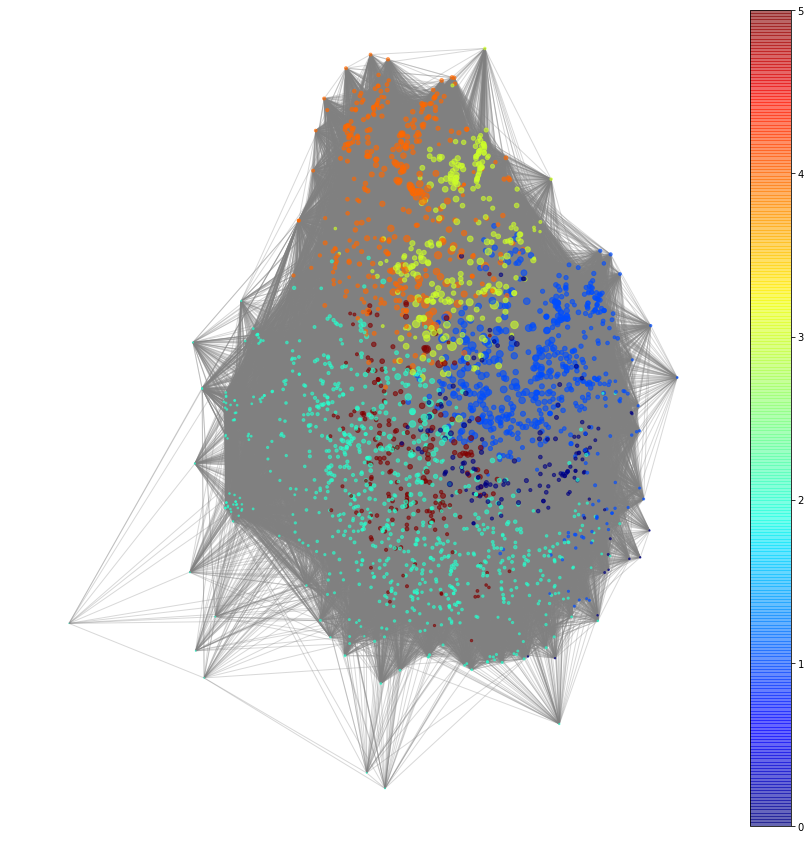

In [41]:
partition = community.best_partition(grafo, weight='weight')
node_color = [partition.get(node) for node in grafo.nodes()]
node_size = [eigen * 1000 for eigen in list(nx.eigenvector_centrality(grafo, weight='weight').values())]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo, pos=pos, alpha=0.3, edge_color='gray')
no = nx.draw_networkx_nodes(grafo, pos=pos, alpha=0.6, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=0.0, vmax=max(partition.values()),
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')

In [42]:
likes_completo['cluster'] = likes_completo['id'].apply(
    lambda x: partition[str(x)] if str(x) in list(partition.keys()) else None)

d:\git\analysis-geospatial-data\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
likes_com_cluster = likes_completo[~likes_completo['cluster'].isnull()]

In [44]:
likes_com_cluster.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng,cluster
120843,79439436,Lauren,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205,2.0
120858,11928,David 🎉,male,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205,2.0
120860,1522042,Marie,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205,2.0
120868,1226733,Brittney,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205,2.0
120875,23147845,Lindsey,female,534e9a2211d247e3854371f2,Peloton,Cycle Studio,40.743469,-73.994205,2.0


In [45]:
len(likes_com_cluster)

6670

In [3]:
#likes_com_cluster.to_csv('victor_likes_NY_geral_cluster.csv', index=False)

In [4]:
likes_com_cluster = pd.read_csv('victor_likes_NY_geral_cluster.csv')

In [46]:
likes_com_cluster[likes_com_cluster['cluster'] == 0]['avenue_name'].value_counts()[:3]

Carl Schurz Park    124
City Swiggers        27
East Meadow          25
Name: avenue_name, dtype: int64

In [47]:
likes_com_cluster[likes_com_cluster['cluster'] == 1]['avenue_name'].value_counts()[:3]

Jacqueline Kennedy Onassis Reservoir    290
Bethesda Fountain                       254
Bethesda Terrace                        103
Name: avenue_name, dtype: int64

In [48]:
likes_com_cluster[likes_com_cluster['cluster'] == 2]['avenue_name'].value_counts()[:3]

Sakagura                                139
Le Bernardin                            121
KazuNori: The Original Hand Roll Bar    109
Name: avenue_name, dtype: int64

In [49]:
likes_com_cluster[likes_com_cluster['cluster'] == 3]['avenue_name'].value_counts()[:3]

Gantry Plaza State Park      250
Hunter's Point South Park     98
Astoria Park                  41
Name: avenue_name, dtype: int64

In [50]:
likes_com_cluster[likes_com_cluster['cluster'] == 4]['avenue_name'].value_counts()[:3]

Astoria Park    173
Milkflower      166
Il Bambino      165
Name: avenue_name, dtype: int64

In [51]:
likes_com_cluster[likes_com_cluster['cluster'] == 5]['avenue_name'].value_counts()[:3]

Park Avenue Armory    178
Gagosian Gallery       53
The Noguchi Museum     40
Name: avenue_name, dtype: int64

In [52]:
influentes = []
dic = nx.degree_centrality(grafo)
for v in sorted(dic, key=dic.get, reverse=True):
    influentes.append(v)
likes_com_cluster[likes_com_cluster['id'].isin(influentes[:10])][['firstName', 'gender', 'cluster']].drop_duplicates()

,firstName,gender,cluster
8339,JRA,none,3.0
8340,Alex,male,1.0
8401,Emily,female,5.0
8554,Kino,male,4.0
8787,John,male,1.0
8799,Philip,male,1.0
8823,Carolyn,female,1.0
28896,Garrett,male,1.0
35586,Nathan,male,1.0
35649,Dmtiry,male,1.0
